In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Import the data set, and get all sentences
import pandas as pd

df = pd.read_json('datasets/train.json')
print(df['tag'].unique())

['phone call' 'meeting' 'face-to-face conversation' 'general chatting'
 'presentation' 'training']


In [3]:
df

,id,tag,title,original_language,conversation
0,190329_J07_03,phone call,伝言への折り返し電話 打ち合わせ日程調整,ja,"[{'no': 1, 'ja_speaker': '土井さん', 'en_speaker':..."
1,190329_J06_11,meeting,株主総会に関する役員向け説明（２）,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
2,190329_J06_10,meeting,株主総会に関する役員向け説明（１）,ja,"[{'no': 1, 'ja_speaker': '友井さん', 'en_speaker':..."
3,190329_J06_09,face-to-face conversation,信託銀行から株主名簿を受領,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
4,190329_J06_08,face-to-face conversation,株主総会への臨場要請,ja,"[{'no': 1, 'ja_speaker': '高田さん', 'en_speaker':..."
...,...,...,...,...,...
665,190315_E001_05,presentation,Presentation: Company introduction,en,"[{'no': 1, 'en_speaker': 'Mr. Asano Yuki', 'ja..."
666,190315_E001_04,training,Training: training a new employee,en,"[{'no': 1, 'en_speaker': 'Mr. Ben Sherman', 'j..."
667,190315_E001_03,general chatting,General chatting: Company Christmas party,en,"[{'no': 1, 'en_speaker': 'Ms. Amy Lin', 'ja_sp..."
668,190315_E001_02,phone call,Phone call: requesting a lunch meeting.,en,"[{'no': 1, 'en_speaker': 'Mr. John Smith', 'ja..."


In [4]:

df_convs = pd.concat([pd.json_normalize(df['conversation'][i]) for i in range(len(df))],ignore_index=True)
trainen = df_convs["en_sentence"].values.tolist()
trainja = df_convs["ja_sentence"].values.tolist()

In [5]:
df_convs

,no,ja_speaker,en_speaker,ja_sentence,en_sentence
0,1,土井さん,Doi-san,はい、K社システム開発部です。,Hi this is the systems development department ...
1,2,高市さん,Takaichi-san,H社の高市と申します。,My name is Takaichi from Company H.
2,3,高市さん,Takaichi-san,いつもお世話になっております。,Thank you as always.
3,4,土井さん,Doi-san,こちらこそ、お世話になっております。,Thank you as always as well.
4,5,高市さん,Takaichi-san,稲田さんはいらっしゃいますか？,Is Inada-san there?
...,...,...,...,...,...
19995,28,ボブ クックさん,Mr. Bob Cook,今日の5時までに書き上げます。,I'll finish it by 5 o'clock today.
19996,29,アル ジョンソンさん,Mr. Al Johnson,完璧だね。,Perfect.
19997,30,アル ジョンソンさん,Mr. Al Johnson,明日ゼネラルマネージャーにA社の件を話しておきますね。,I'll go talk to the general manager tomorrow t...
19998,31,アル ジョンソンさん,Mr. Al Johnson,彼がA社を気に入ってくれて、投資できる方向に決まることを願いましょう。,Hopefully he will like Company A and make the ...


In [6]:

len(trainen)

20000

In [7]:
trainen[100:160]

['What do you think about the contents from your perspective, Nose-san?',
 "Well the number of shareholders is stable and I don't see any suspicious shareholder's name.",
 'I think we can take a breather?',
 'Right.',
 "I will take a closer look later but it doesn't seem there are any large concerns from the look of it.",
 'Also, I get the feeling of being pressed with the wave of year end events when I get the register of shareholders.',
 'Feeling overwhelmed?',
 "Well, it can't be helped.",
 "It's an annual thing but we just have to work hard for the next 2 months and get through it.",
 'I am relying on you Nose-san, seriously.',
 'Anyways, I will make a draft of the scenario for the general meeting so can I get you to check it?',
 "I will be making this year's version based on last year's scenario.",
 "You don't have to rush that much in terms of time, right?",
 'Yeah, there is the announcement of financial results first.',
 'First, the schedule around the general meeting is as show

In [8]:
#concat all english messages
text = ' '.join(trainen[0:10000]) # Out of RAM if we use all the data
print('length of the corpus is: :', len(text))

length of the corpus is: : 532978


In [9]:

# tokenizer
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [10]:
# get unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))


In [13]:
len(unique_words)
unique_words[1000:1030]

array(['Shanghai', 'She', 'Shibata', 'Shibuya', 'Shiota', 'Shiraishi',
       'Shiroki', 'Shirota', 'Shizuo', 'Shodoshima', 'Shop', 'Should',
       'Shouldn', 'Shuji', 'Silence', 'Silicone', 'Similar', 'Since',
       'Sir', 'Six', 'Skiing', 'Smith', 'So', 'Soji', 'Some', 'Somebody',
       'Someone', 'Something', 'Sometimes', 'Somewhere'], dtype='<U16')

In [14]:
# model input = prev_words
# model output = next_words

WORD_LENGTH = 5
next_words = []
prev_words = []
for j in range(len(words) - WORD_LENGTH):
     prev_words.append(words[j:j + WORD_LENGTH])
     next_words.append(words[j + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['Hi', 'this', 'is', 'the', 'systems']
development


In [15]:
# convert features into numpy arrays
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
# prepare word2id index
for i, each_words in enumerate(prev_words):
   for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
   Y[i, unique_word_index[next_words[i]]] = 1
word2id = unique_word_index

In [16]:

# prepare id2word index ==> for inference
id2word = {y:x for x,y in unique_word_index.items()}

In [41]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [42]:
# train model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history


Epoch 1/2
769/769 [==============================] - 133s 165ms/step - loss: 5.8181 - accuracy: 0.1265 - val_loss: 5.5573 - val_accuracy: 0.1605
Epoch 2/2
769/769 [==============================] - 133s 173ms/step - loss: 5.3962 - accuracy: 0.1834 - val_loss: 5.9657 - val_accuracy: 0.1754


In [31]:
history

{'loss': [5.823361396789551, 5.431649684906006],
 'accuracy': [0.1273365169763565, 0.1803213655948639],
 'val_loss': [5.573983192443848, 5.926844120025635],
 'val_accuracy': [0.17098145186901093, 0.18411901593208313]}

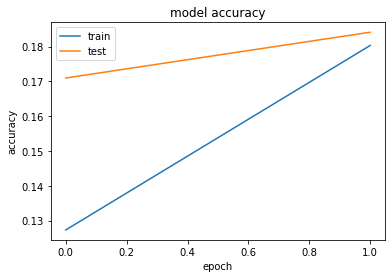

In [32]:
# evaluate model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

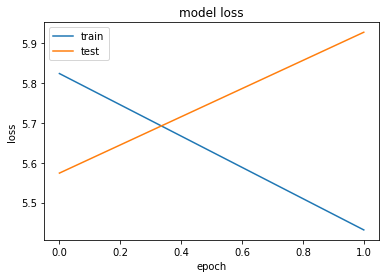

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')